# AMAL : TP3

In [1]:
from torch.utils.data import Dataset , DataLoader
import numpy as np
import random

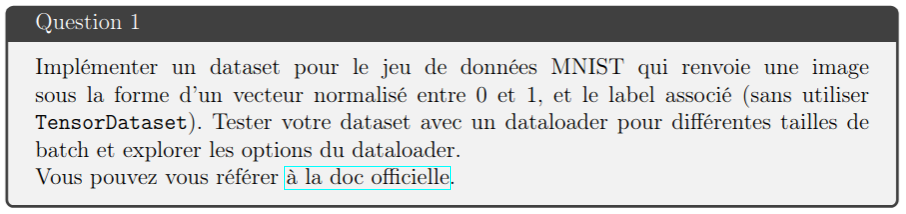

In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

In [3]:
uspsdatatrain = "./data/USPS_train.txt"
uspsdatatest = "./data/USPS_test.txt"
alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)

In [4]:
print(alltrainx.shape,alltrainy.shape)
print(alltestx.shape,alltesty.shape)

(7291, 256) (7291,)
(2007, 256) (2007,)


In [5]:
alltrainx /= 2
alltestx /= 2

In [6]:
class MonDataSet(Dataset) :
    
    def __init__(self,X,y) :
        self.X = X
        self.y = y
    
    def __getitem__(self,index) :
        """
        retourne couple exemple,label
        """
        return self.X[index],self.y[index]
    
    def __len__(self) :
        """
        renvoit la taille du jeu de données
        """
        return len(self.X)

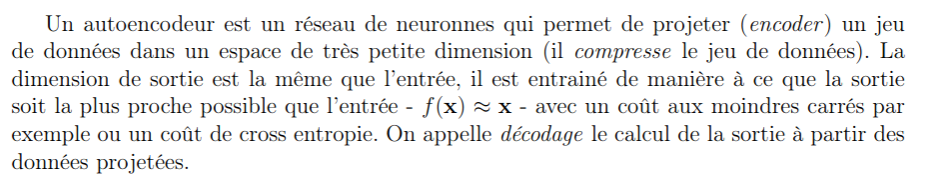

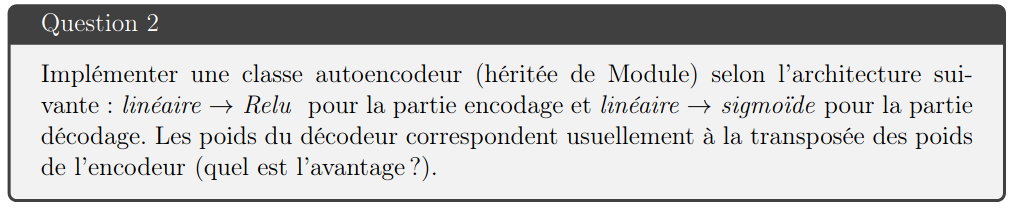

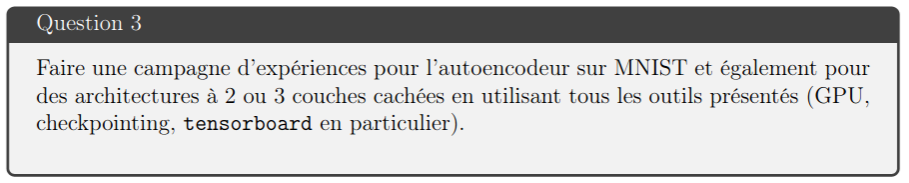

In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [20]:
class Encoder(nn.Module) :
    
    def __init__(self,nb_input,nb_output) :
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(nb_input,25),
            nn.ReLU()
        )
                
    def forward(self,x):
        return self.net(x)

class Decoder(nn.Module) :
    
    def __init__(self,nb_input,nb_output) :
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(25,nb_output),
            nn.Tanh()
        )
            
    def forward(self,x) :
        return self.net(x)
    
class AutoEncodeur(nn.Module) :
    
    def __init__(self,encoder,decoder) :
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [21]:
dl = DataLoader(MonDataSet(alltrainx, alltrainx), shuffle=True, batch_size=64)

In [22]:
nb_eval = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f"device used : {device}")

encoder = Encoder(alltrainx.shape[1],alltrainx.shape[1]).to(device)
decoder = Decoder(alltrainx.shape[1],alltrainx.shape[1]).to(device)

autoencoder = AutoEncodeur(encoder,decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
writer = SummaryWriter("./runs/tp3_mse_usps")

for i in tqdm(range(nb_eval)):

    for X,y in dl:

        X_t = torch.as_tensor(X, dtype=torch.float32,device=device)
        y_t = torch.as_tensor(y, dtype=torch.float32,device=device)
        
        y_pred = autoencoder(X_t)
        mse = torch.nn.MSELoss()
        # mse = torch.nn.CrossEntropyLoss()
        loss = mse(y_pred,y_t)
        
        # log
        writer.add_scalar('TP3 : Loss/train USPS', loss.cpu().detach().numpy(), i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

device used : cpu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  5.15it/s]


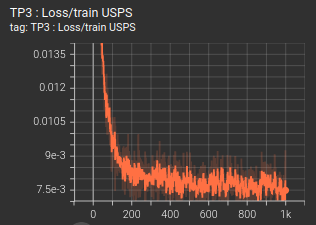

In [36]:
index_tests = random.choices(np.arange(len(alltrainx)) , k=10)

In [ ]:
test_data_1 = alltrainx[index_tests]
test_data_1_t = torch.as_tensor(test_data_1, dtype=torch.float32, device=device)

z_1 = encoder(test_data_1_t)
z_1_n = z_1.detach().numpy()

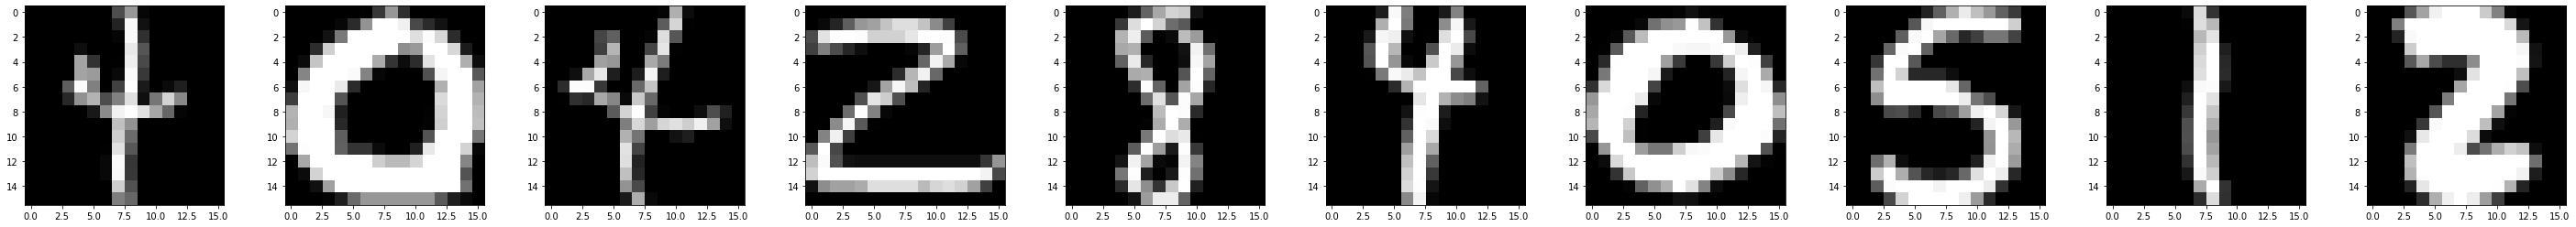

In [48]:
fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(test_data_1[i].reshape(16,16),cmap='gray')

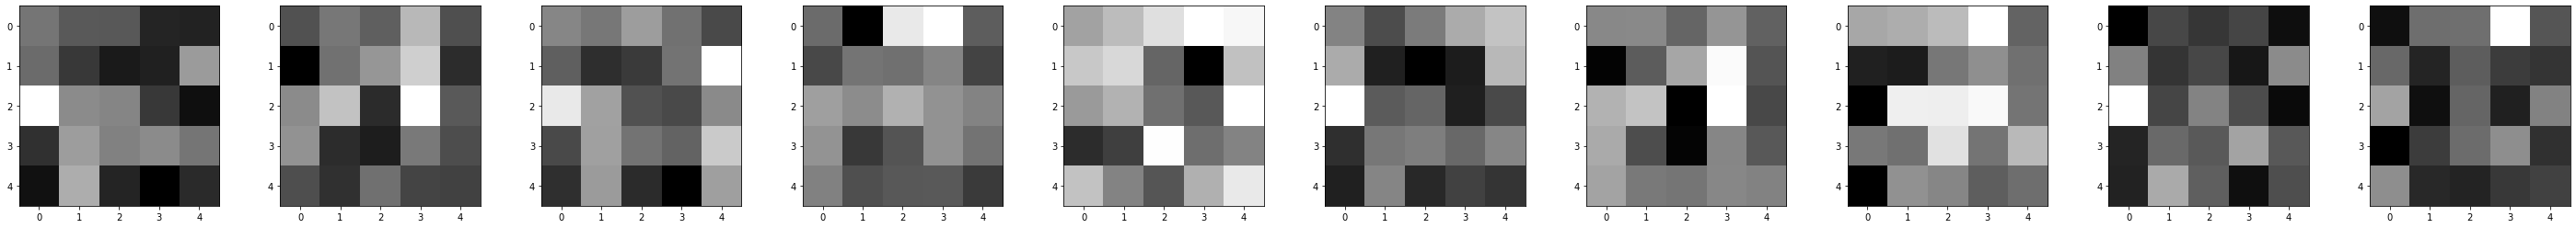

In [49]:
fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(z_1_n[i].reshape(5,5),cmap='gray')

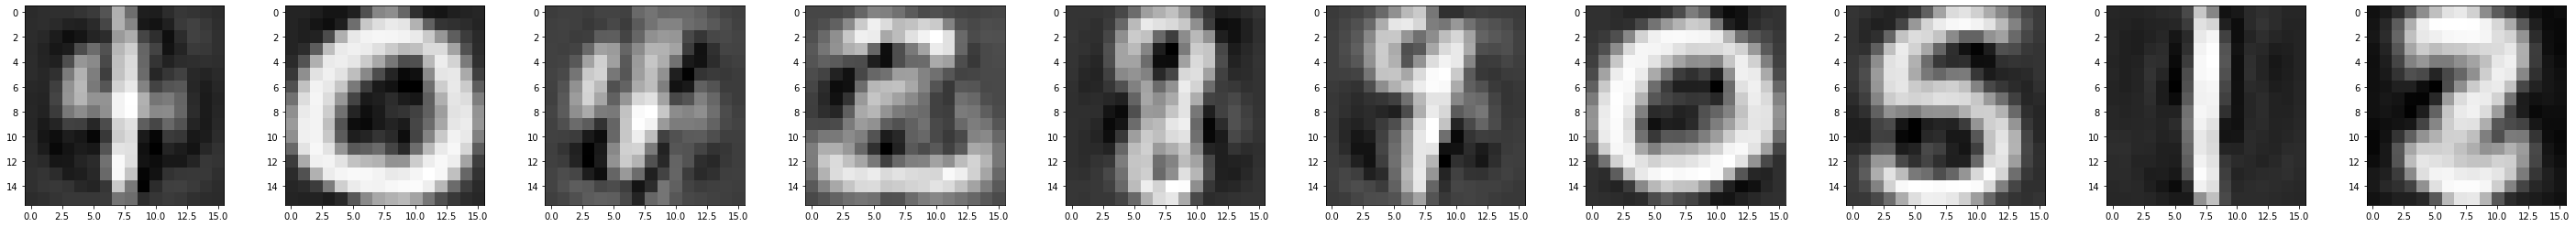

In [50]:
z_1_decode = decoder(z_1).detach().numpy()

fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(z_1_decode[i].reshape(16,16),cmap='gray')

Obeservation : tendance à floutté les chiffres

In [51]:
nb_eval = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f"device used : {device}")

encoder = Encoder(alltrainx.shape[1],alltrainx.shape[1]).to(device)
decoder = Decoder(alltrainx.shape[1],alltrainx.shape[1]).to(device)

autoencoder = AutoEncodeur(encoder,decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
writer = SummaryWriter("./runs/tp3_ce_usps")

for i in tqdm(range(nb_eval)):

    for X,y in dl:

        X_t = torch.as_tensor(X, dtype=torch.float32,device=device)
        y_t = torch.as_tensor(y, dtype=torch.float32,device=device)
        
        y_pred = autoencoder(X_t)
        ce = torch.nn.CrossEntropyLoss()
        loss = ce(y_pred,y_t)
        
        # log
        writer.add_scalar('TP3 : Loss/train USPS', loss.cpu().detach().numpy(), i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

device used : cpu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.48it/s]


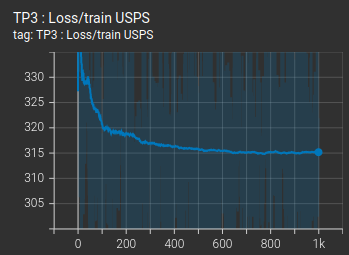

In [52]:
test_data_1 = alltrainx[index_tests]
test_data_1_t = torch.as_tensor(test_data_1, dtype=torch.float32, device=device)

z_1 = encoder(test_data_1_t)
z_1_n = z_1.detach().numpy()

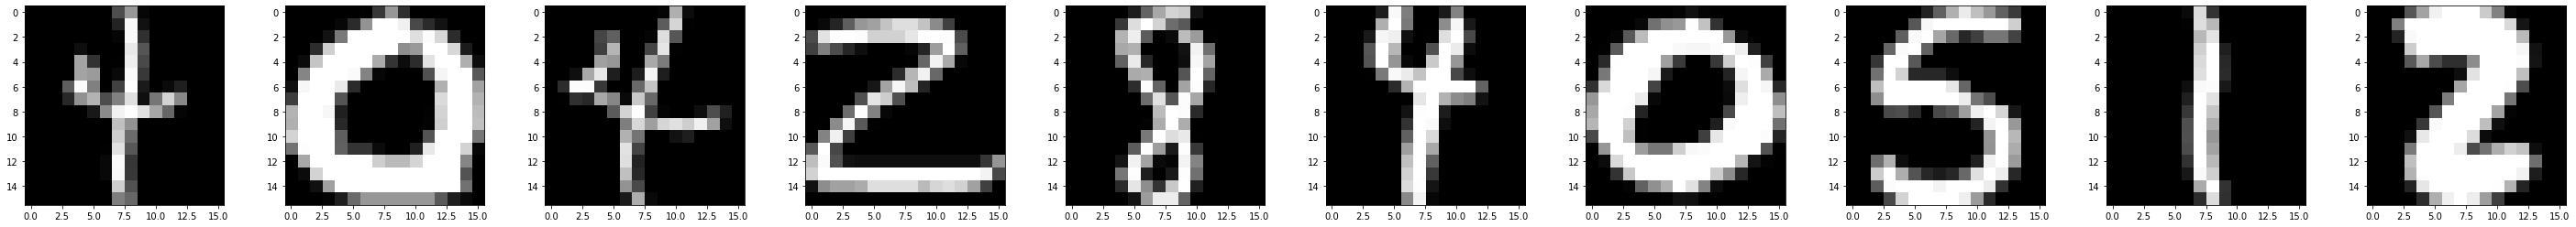

In [53]:
fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(test_data_1[i].reshape(16,16),cmap='gray')

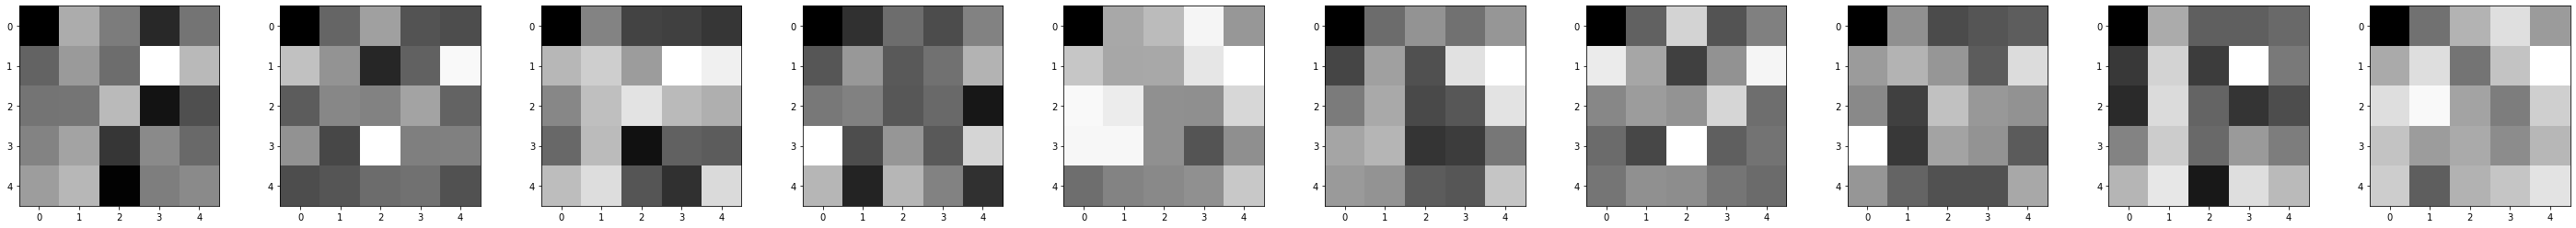

In [54]:
fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(z_1_n[i].reshape(5,5),cmap='gray')

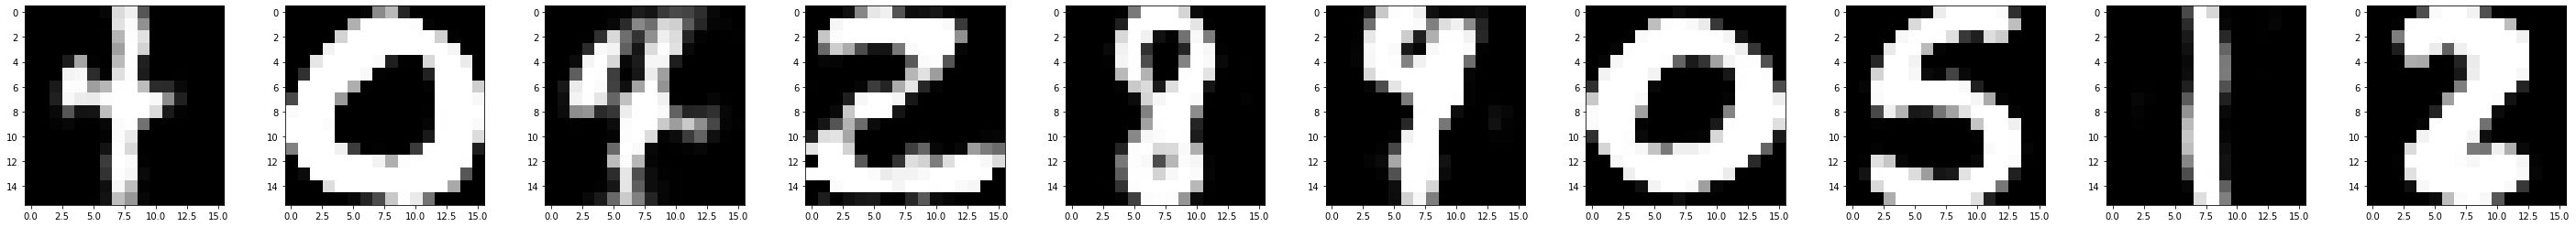

In [55]:
z_1_decode = decoder(z_1).detach().numpy()

fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(z_1_decode[i].reshape(16,16),cmap='gray')

Observation : tendance à grossir les chiffres (mettre en gras)

## Réseau à deux couches

In [56]:
class Encoder2(nn.Module) :
    
    def __init__(self,nb_input,nb_output) :
        super().__init__()
        
        # 2 couches cachées
        self.net = nn.Sequential(
            nn.Linear(nb_input,100),
            nn.ReLU(),
            nn.Linear(100,25),
            nn.ReLU()
        )
                
    def forward(self,x):
        return self.net(x)

class Decoder2(nn.Module) :
    
    def __init__(self,nb_input,nb_output) :
        super().__init__()
        
        # 2 couches cachées
        self.net = nn.Sequential(
            nn.Linear(25,100),
            nn.Tanh(),
            nn.Linear(100,nb_output),
            nn.Tanh()
        )
            
    def forward(self,x) :
        return self.net(x)
    
class AutoEncodeur2(nn.Module) :
    
    def __init__(self,encoder,decoder) :
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [57]:
nb_eval = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f"device used : {device}")

encoder = Encoder2(alltrainx.shape[1],alltrainx.shape[1]).to(device)
decoder = Decoder2(alltrainx.shape[1],alltrainx.shape[1]).to(device)

autoencoder = AutoEncodeur2(encoder,decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
writer = SummaryWriter("./runs/tp3_mse_2_usps")

for i in tqdm(range(nb_eval)):

    for X,y in dl:

        X_t = torch.as_tensor(X, dtype=torch.float32,device=device)
        y_t = torch.as_tensor(y, dtype=torch.float32,device=device)
        
        y_pred = autoencoder(X_t)
        mse = torch.nn.MSELoss()
        # mse = torch.nn.CrossEntropyLoss()
        loss = mse(y_pred,y_t)
        
        # log
        writer.add_scalar('TP3 : Loss/train USPS', loss.cpu().detach().numpy(), i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

device used : cpu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:19<00:00,  3.13it/s]


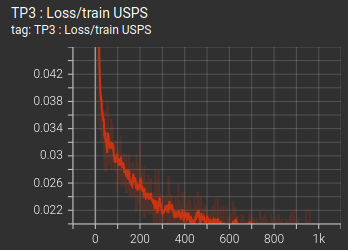

In [58]:
test_data_1 = alltrainx[index_tests]
test_data_1_t = torch.as_tensor(test_data_1, dtype=torch.float32, device=device)

z_1 = encoder(test_data_1_t)
z_1_n = z_1.detach().numpy()

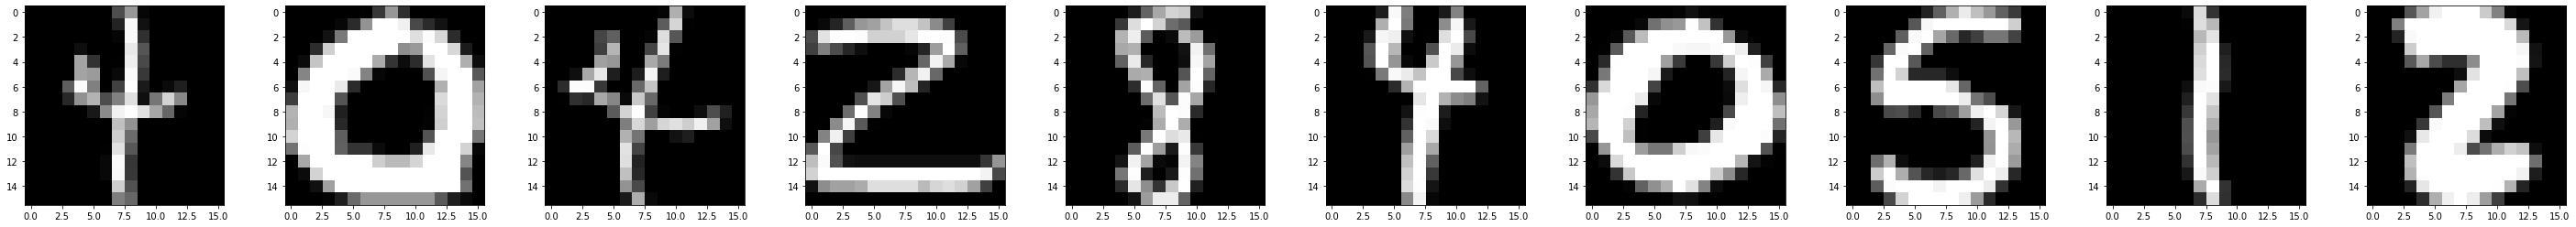

In [59]:
fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(test_data_1[i].reshape(16,16),cmap='gray')

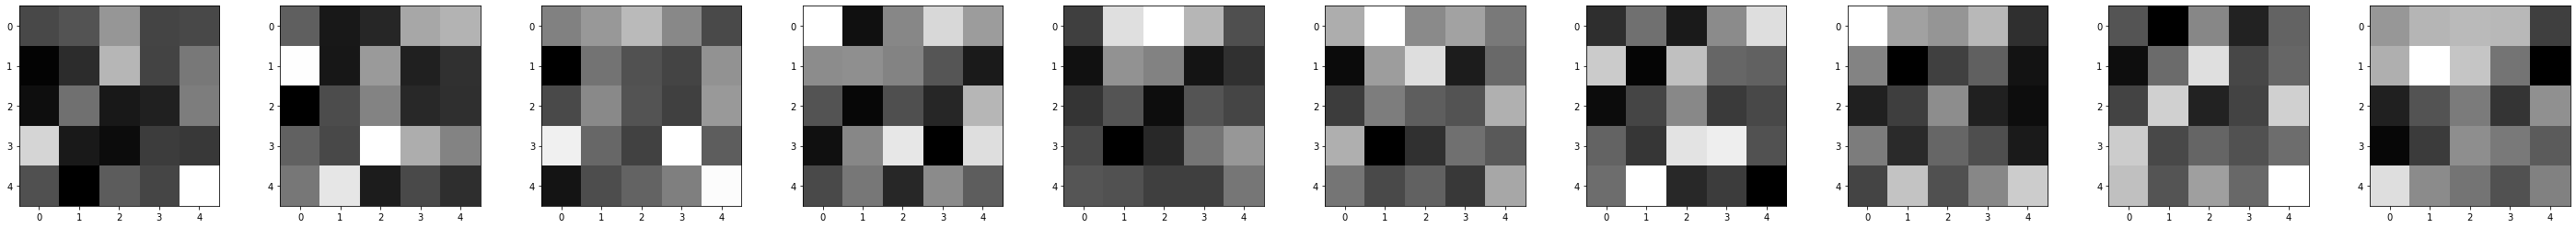

In [60]:
fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(z_1_n[i].reshape(5,5),cmap='gray')

Représentation du décodage de l’interpolation des représentation de deux images :

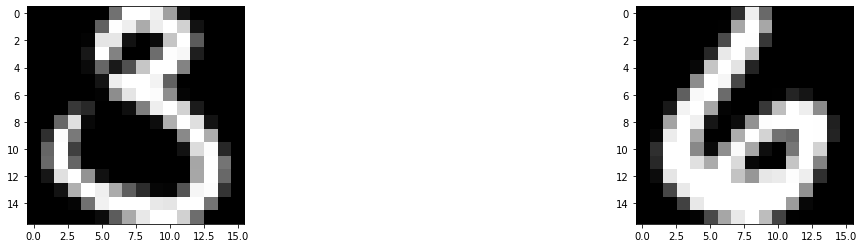

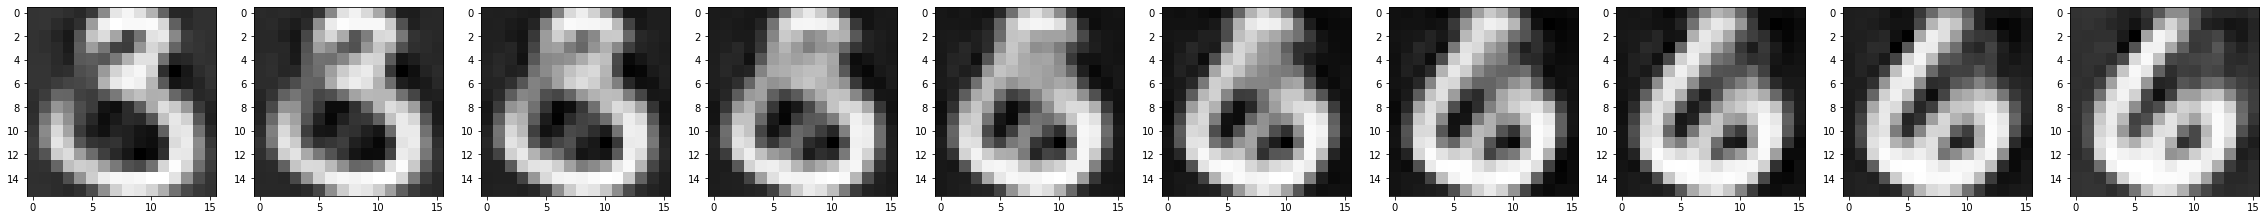

In [94]:
lambda_value = np.linspace(0,1,10)
fig, axs = plt.subplots(1,2)
fig.set_figwidth(20)

index1 = 0
index2 = 30

img1 = torch.as_tensor(alltrainx[index1],dtype=torch.float32,device=device)
img2 = torch.as_tensor(alltrainx[index2],dtype=torch.float32,device=device)

axs[1].imshow(alltrainx[index1].reshape(16,16),cmap='gray')
axs[0].imshow(alltrainx[index2].reshape(16,16),cmap='gray')
    
    
interpolations = list()
for i in range(len(lambda_value)):
    interpolation = lambda_value[i] * encoder(img1) + (1 - lambda_value[i]) * encoder(img2)
    interpolations.append(interpolation.detach().numpy())

results = list()
for i in range(len(lambda_value)):
    interpolation_t = torch.as_tensor(interpolations[i], dtype=torch.float32, device = device)
    results.append(decoder(interpolation_t))
   

fig,axs = plt.subplots(1,len(lambda_value))
fig.set_figwidth(40)
for i in range(len(lambda_value)): 
    axs[i].imshow(results[i].detach().numpy().reshape(16,16),cmap='gray')

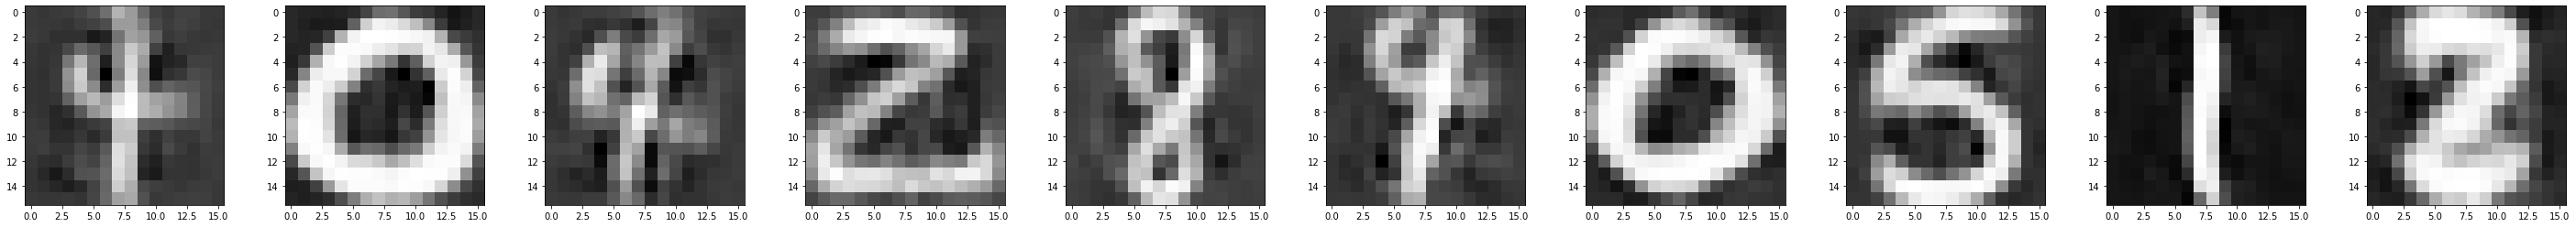

In [61]:
z_1_decode = decoder(z_1).detach().numpy()

fig, axs = plt.subplots(1,10)
fig.set_figwidth(50)

for i in range(10):
    axs[i].imshow(z_1_decode[i].reshape(16,16),cmap='gray')

# Réseau à trois couches

# Highway Network

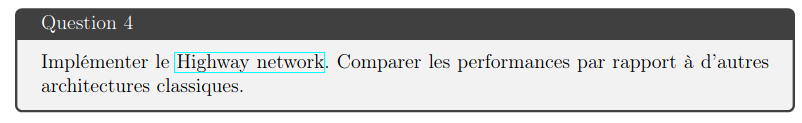

source : https://arxiv.org/pdf/1505.00387.pdf

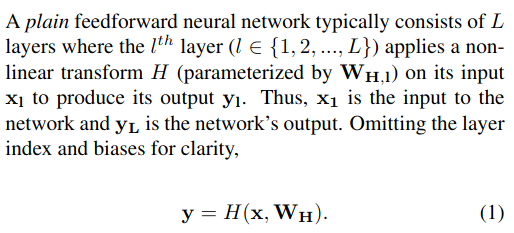

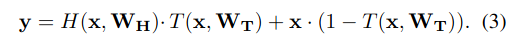

In [142]:
class HighwayNetwork(nn.Module) :
    
    def __init__(self,nb_input,nb_layers,nb_output,device) :
        super().__init__()
        
        self.h_functions = nn.ModuleList([nn.Sequential(
            nn.Linear(nb_input,nb_input),
            nn.ReLU()
        )  for _ in range(nb_layers)])
        
        
        self.t_functions = nn.ModuleList([nn.Sequential(
            nn.Linear(nb_input,nb_input),
            nn.Sigmoid()
        )  for _ in range(nb_layers)])
        
        self.last_output = nn.Sequential(
            nn.Linear(nb_input,nb_output),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x) :
        
        for h,t in zip(self.h_functions,self.t_functions) :
        
            x = ( h(x) * t(x) ) + ( x * (1 - t(x)) )
            
        return self.last_output(x)
        
class ClassicNetwork(nn.Module) : 
    
    
    def __init__(self,nb_input,nb_layers,nb_output,device) :
        super().__init__()
        
        self.layers = nn.ModuleList([nn.Sequential(
            nn.Linear(nb_input,nb_input),
            nn.ReLU()
        )  for _ in range(nb_layers)])
        
        self.last_output = nn.Sequential(
            nn.Linear(nb_input,nb_output),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        for layer in self.layers :
        
            x = layer(x)
            
        return self.last_output(x)

In [137]:
nb_output = len(np.unique(alltrainy))
nb_layers = 10

In [138]:
def OneHotEncoding(y):
    onehot = np.zeros((y.size,y.max()+1))
    onehot[np.arange(y.size),y]=1
    return onehot

dl = DataLoader(MonDataSet(alltrainx, OneHotEncoding(alltrainy)), shuffle=True, batch_size=64)

In [141]:
nb_eval = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f"device used : {device}")

classic_network = ClassicNetwork(alltrainx.shape[1],nb_layers,nb_output,device).to(device)
optimizer = torch.optim.Adam(classic_network.parameters(), lr=0.0001)

writer = SummaryWriter("./runs/tp3_classic_usps")

for i in tqdm(range(nb_eval)):

    for X,y in dl:

        X_t = torch.as_tensor(X, dtype=torch.float32,device=device)
          
        y_t = torch.as_tensor(y, dtype=torch.float32,device=device)
        
        y_pred = classic_network(X_t)
        
        ce = torch.nn.CrossEntropyLoss()
        
        loss = ce(y_pred,y_t)
        
        # log
        writer.add_scalar('TP3 : Loss/train USPS', loss.cpu().detach().numpy(), i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

device used : cuda


100%|███████████████████████████████████████| 1000/1000 [08:41<00:00,  1.92it/s]


In [143]:
nb_eval = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f"device used : {device}")

highway_network = HighwayNetwork(alltrainx.shape[1],nb_layers,nb_output,device).to(device)
optimizer = torch.optim.Adam(highway_network.parameters(), lr=0.0001)

writer = SummaryWriter("./runs/tp3_highway_usps")

for i in tqdm(range(nb_eval)):

    for X,y in dl:

        X_t = torch.as_tensor(X, dtype=torch.float32,device=device)
          
        y_t = torch.as_tensor(y, dtype=torch.float32,device=device)
        
        y_pred = highway_network(X_t)
        
        ce = torch.nn.CrossEntropyLoss()
        
        loss = ce(y_pred,y_t)
        
        # log
        writer.add_scalar('TP3 : Loss/train USPS', loss.cpu().detach().numpy(), i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

device used : cuda


100%|███████████████████████████████████████| 1000/1000 [19:42<00:00,  1.18s/it]


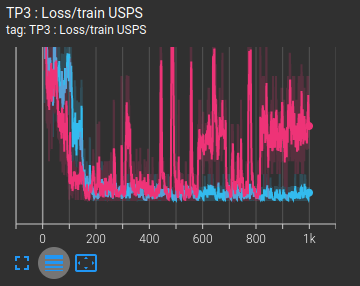

en bleu : Highway / en rouge : classic

In [147]:
X_train_t = torch.as_tensor(alltrainx, dtype=torch.float32,device=device)
X_test_t = torch.as_tensor(alltestx, dtype=torch.float32,device=device)

y_train_pred = torch.argmax(highway_network(X_train_t),dim=1).cpu().detach().numpy()
y_test_pred = torch.argmax(highway_network(X_test_t),dim=1).cpu().detach().numpy()

ratio_train = (alltrainy == y_train_pred).mean() * 100
ratio_test = (alltesty == y_test_pred).mean() * 100

print(f"accuracy du highway network en train : {ratio_train}%")
print(f"accuracy du highway network en test : {ratio_test}%")

accuracy du highway network en train : 99.50624057056645%
accuracy du highway network en test : 93.12406576980567%


In [148]:
X_train_t = torch.as_tensor(alltrainx, dtype=torch.float32,device=device)
X_test_t = torch.as_tensor(alltestx, dtype=torch.float32,device=device)

y_train_pred = torch.argmax(classic_network(X_train_t),dim=1).cpu().detach().numpy()
y_test_pred = torch.argmax(classic_network(X_test_t),dim=1).cpu().detach().numpy()

ratio_train = (alltrainy == y_train_pred).mean() * 100
ratio_test = (alltesty == y_test_pred).mean() * 100

print(f"accuracy du network classic en train : {ratio_train}%")
print(f"accuracy du network classic en test : {ratio_test}%")

accuracy du network classic en train : 90.30311342751337%
accuracy du network classic en test : 86.89586447433982%
